# Simple NN with Haiku.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/main/examples/haiku_example.ipynb)

This notebook trains a simple one-layer NN with Optax and Haiku.

In [1]:
import optax
import jax
import jax.numpy as jnp
import haiku as hk
import matplotlib.pyplot as plt

In [2]:
# @markdown Learning rate for the optimizer:
LEARNING_RATE = 1e-2  # @param{type:"number"}
# @markdown Number of training steps:
NUM_STEPS = 100  # @param{type:"integer"}
# @markdown Number of samples in a batch:
BATCH_SIZE = 64  # @param{type:"integer"}
# @markdown Shape of the input:
X_DIM = 10  # @param{type:"integer"}


In this cell, we initialize a random number generator (RNG), which will be used to generate the training dataset.

In [3]:
key_seq = hk.PRNGSequence(1729)

In the next cell, we define a model and obtain its initial parameters.

In [4]:
def forward_pass(x):
  return hk.Linear(10)(x)

net = hk.without_apply_rng(hk.transform(forward_pass))
params = net.init(next(key_seq), jnp.zeros([1, X_DIM]))

Next we define a custom loss function.
By minimising this loss, we aim to adjust the parameters of the model such that its output values are close to zero.

In [5]:
def sum_squared_loss(params, x):
  output = net.apply(params, x)
  loss = jnp.sum(output**2)
  return loss

value_and_grad_fn = jax.value_and_grad(sum_squared_loss)

In the next cell, we construct a simple Adam optimiser using Optax gradient transformations passed to the `optax.chain`. Here the optimiser is represented by its initialisation function `opt_init` and the function `opt_update` that takes gradients, the previous optimizer state, and the current model parameters and returns the computed gradient updates, and a new optimizer state.

The same result can be achieved by using the `optax.adam` alias. However, here, we demonstrate how to work with gradient transformations manually so that you can build your own custom optimiser if needed.

In [6]:
opt_init, opt_update = optax.chain(
    # Sets the parameters of Adam. Note the learning_rate is not here.
    optax.scale_by_adam(b1=0.9, b2=0.999, eps=1e-8),
    # Puts a minus sign to *minimise* the loss.
    optax.scale(-LEARNING_RATE)
)

We then pass the initial parameters of the model to the optimiser's init function to obtain its initial parameters.

In [7]:
opt_state = opt_init(params)

Finally, we train the model for `NUM_STEPS` steps.

In [8]:
loss_history = []

for _ in range(NUM_STEPS):
  data = jax.random.normal(next(key_seq), [BATCH_SIZE, X_DIM])
  # Computes loss values of the loss function.
  loss, grad = value_and_grad_fn(params, data)
  loss_history.append(loss)
  # Transforms the gradients using the optimiser.
  updates, opt_state = opt_update(grad, opt_state, params)
  # Updates parameters.
  params = optax.apply_updates(params, updates)

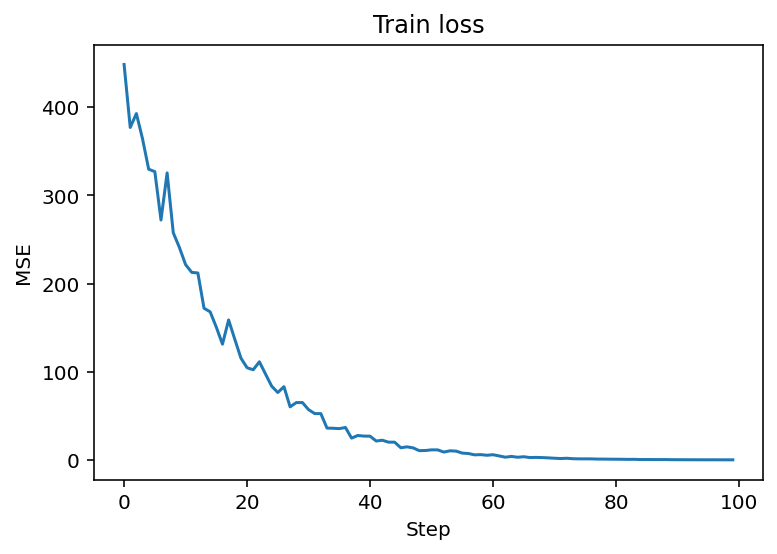

In [9]:
plt.plot(loss_history)
plt.title('Train loss')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.show()